In [1]:
import pymc3 as pm
import numpy as np
import theano

from theano.compile.ops import as_op

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("/home/daniel/papers/thesis/thesis-style.mpl")

In [2]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
def background_rate_f(b, T, n):
    """
    
    """
    out = 0
    #n = int(n)
    for i in range(n+1):
        out += ((b*T)**i * np.exp(- b*T)) / np.math.factorial(i)
    return out

def log_background_rate(b, T, n):
    return np.log(background_rate_f(b, T, n))

def signal_rate_part(s, n, b, T):
    top_a = T * ((s + b) * T)**n 
    top_b = np.exp(-(s + b)*T)
    p = (top_a * top_b) / np.math.factorial(n)
    return theano.tensor.switch(theano.tensor.le(s, 0), 0, p)

#@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dscalar])
def log_signal_rate(s,n,b,T):
    #if theano.tensor.lt(0, s): return np.array([[0.0]])
    p = -log_background_rate(b,T,n) + np.log(signal_rate_part(s,n,b,T))
    
    return p

In [16]:
def beaming_violins(traces, priors):

    width = 3.487 #* 2
    height = width / 1.618


    f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))
    priors = ["U(0,1)", "Jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
    print "|\t\t\t| Lower\t| MAP\t| Median\t| Upper\t|"
    print "|----------|"
    matplotlib.rcParams.update({'font.size': 10})
    pos = [.5, 1, 1.5, 2]

    for i in range(len(priors)):

        o2_trace = traces[i]
        #o2_trace = o2_traces[i]

        #i = i/2.0
        t_data = o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]
        data = np.rad2deg(t_data)

        parts = ax.violinplot(data, [pos[i]], points=100, widths=0.3, vert= False,
                         #showmeans = True, showmedians=True, 
                          showmeans=False, showextrema=False, showmedians=False)

        lower_p, medians, upper_p = np.percentile(data, [2.5, 50, 97.50])
        lower, upper = pymc3.stats.hpd(t_data, alpha=0.05, transform=np.rad2deg)
        hist = np.histogram(data, bins = 90)
        MAP = hist[1][np.argmax(hist[0])]



        ax.hlines(pos[i], lower, upper, color='#333333', linestyle='-', lw=2, alpha = 0.5)

        ax.scatter( [lower, upper], [pos[i]]*2, marker='|', color='k', s=15, zorder=3)
        ax.scatter( [MAP], pos[i], marker='D', color='k', s=15, zorder=3)
        ax.scatter( [medians], pos[i], marker='s', color='k', s=15, zorder=3)
        #ax2.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

        print "| {} \t| {:.2f}\t| {:.2f}\t| {:.2f}\t| {:.2f}\t|".format(priors[i], lower, MAP, medians, upper)

        axis = ax
        axis.set_yticks(pos)
        axis.set_yticklabels(priors)
        axis.set_xlim([0, 52])
        ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.grid(b=True, axis='x', which='major', linewidth=0.5)
        ax.grid(b=True, axis='y', which='major', linewidth=0)
        #ax.grid(b=True, which='minor', linewidth=0.5)
    ax.set_xlabel(r"Beaming Angle [$\theta$]")
    ax.set_ylabel(r"Prior Distribution on efficiency")
    ax.tick_params(axis='y',which='both',left='off')
    f.subplots_adjust(0.20, 0.15, .98, .95, wspace=0.05)
    #f.savefig("O2a_beaming_posteriors_violin.pdf")
    #f.savefig("O2a_beaming_posteriors_violin.png", dpi=300)
    return f

# Assuming VT is known perfectly
I start with a model in which VT is known perfectly, and where we do not account for the number of galaxies in the observed volume, and assume that sources can be distributed isotropically, in the same way that the other rates estimates do.

In [224]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform, Normal
from pymc3 import Model
from pymc3 import distributions

def grb_model_non_galaxy(number_events, background_rate, 
              observation_time, volume, grb_rate,
             efficiency_prior = "uniform"):
    with Model() as model:
        signal_rate = pm.DensityDist('signal_rate', 
                            logp=lambda value: log_signal_rate(value, number_events, background_rate, observation_time),
                           testval=50)

        cbc_rate = pm.Deterministic('cbc_rate', signal_rate / volume * 1e9) 
        
        # Allow the efficiency prior to be switched-out
        if efficiency_prior == "uniform":
            efficiency = pm.Uniform('efficiency', 0,1)
        elif efficiency_prior == "jeffreys":
            efficiency = pm.Beta('efficiency', 0.5, 0.5)
        elif isinstance(efficiency_prior, float):
            efficiency = efficiency_prior
        
        def cosangle(cbc_rate, efficiency, grb_rate):
            return T.switch((grb_rate >= cbc_rate*efficiency), -np.Inf, 
                                 (1.0 - ((grb_rate/(cbc_rate*efficiency)))))
        
        costheta = pm.Deterministic('cos_angle', cosangle(cbc_rate, efficiency, grb_rate)
                                    
                                    )

        angle = pm.Deterministic("angle", theano.tensor.arccos(costheta))
        
        return model



In [225]:
priors = ["uniform", "jeffreys", 1.0, 0.5]

In the actual O1 + O2 scenario we had a total VT of 1502060.62853 Mpc^3yr with a sigma of 118341.996612 Mpc^3yr. This is based off a total observation time of 99.0 + 49.8 days (according to Tom Dents notebook for the rates estimate).

In [4]:
O1_analysis_time = 49.8/365.25
O2_analysis_time = 99.0/365.25

In [5]:
total_time = O1_analysis_time + O2_analysis_time

In [6]:
total_vt = 1502060.62853 
total_v  = total_vt / total_time

In [7]:
print total_v

3687013.74039


In [229]:
# Actual O2

number_events = 1 # There were no BNS detections in O1
background_rate = 0.01 # We take the FAR to be 1/100 yr
grb_rate = 10.0 
o2a_models = []
for prior in priors:
    o2a_models.append( grb_model_non_galaxy(number_events, background_rate, total_time, total_v, grb_rate, prior))

In [316]:
samples = 1000000
o2a_traces = []
for model in o2a_models:
    with model:
        step = pm.Metropolis()
        o2a_traces.append(pm.sample(samples, step))

100%|██████████| 1000000/1000000 [02:13<00:00, 7477.37it/s]


|			| Lower	| MAP	| Median	| Upper	|
|----------|
| U(0,1) 	| 3.64	| 7.48	| 11.83	| 39.72	|
| Jeffreys 	| 3.43	| 7.49	| 11.81	| 51.13	|
| $\delta(1)$ 	| 3.40	| 6.23	| 7.67	| 17.04	|
| $\delta(0.5)$ 	| 4.77	| 9.01	| 10.85	| 24.20	|


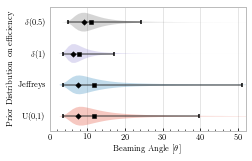

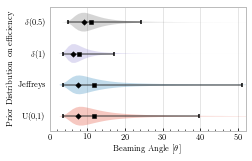

In [317]:
beaming_violins(o2a_traces, priors)

# Assuming VT is distributed
We can also incorporate the uncertainty in VT.

In [12]:
sigma_vt = 118342

In [319]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform, Normal
from pymc3 import Model
from pymc3 import distributions

def grb_model_non_galaxy_sigma(number_events, background_rate, 
              observation_time, volume, sigma_volume, grb_rate,
             efficiency_prior = "uniform"):
    with Model() as model:
        signal_rate = pm.DensityDist('signal_rate', 
                            logp=lambda value: log_signal_rate(value, number_events, background_rate, observation_time),
                           testval=50)

        volume = pm.Normal("volume", volume, sigma_volume)
        
        cbc_rate = pm.Deterministic('cbc_rate', signal_rate / volume * 1e9) 
        
        # Allow the efficiency prior to be switched-out
        if efficiency_prior == "uniform":
            efficiency = pm.Uniform('efficiency', 0,1)
        elif efficiency_prior == "jeffreys":
            efficiency = pm.Beta('efficiency', 0.5, 0.5)
        elif isinstance(efficiency_prior, float):
            efficiency = efficiency_prior
        
        def cosangle(cbc_rate, efficiency, grb_rate):
            return T.switch((grb_rate >= cbc_rate*efficiency), -np.Inf, 
                                 (1.0 - ((grb_rate/(cbc_rate*efficiency)))))
        
        costheta = pm.Deterministic('cos_angle', cosangle(cbc_rate, efficiency, grb_rate)
                                    
                                    )

        angle = pm.Deterministic("angle", theano.tensor.arccos(costheta))
        
        return model



In [320]:
# Actual O2
priors = ["uniform", "jeffreys", 1.0, 0.5]
number_events = 1 # There were no BNS detections in O1
background_rate = 0.01 # We take the FAR to be 1/100 yr
grb_rate = 10.0 
o2a_models_u = []
for prior in priors:
    o2a_models_u.append( grb_model_non_galaxy_sigma(number_events, background_rate, total_time, total_v, sigma_vt/total_time, grb_rate, prior))

In [321]:
samples = 1000000
o2a_traces_u = []
for model in o2a_models_u:
    with model:
        step = pm.Metropolis()
        o2a_traces_u.append(pm.sample(samples, step))

100%|██████████| 1000000/1000000 [02:26<00:00, 6843.46it/s]


|			| Lower	| MAP	| Median	| Upper	|
|----------|
| U(0,1) 	| 3.67	| 7.21	| 11.83	| 39.75	|
| Jeffreys 	| 3.42	| 7.45	| 11.77	| 50.89	|
| $\delta(1)$ 	| 3.44	| 6.26	| 7.67	| 17.07	|
| $\delta(0.5)$ 	| 4.88	| 8.02	| 10.86	| 24.20	|


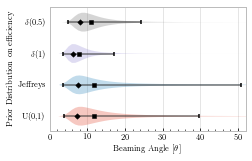

In [322]:
distributed_vt_plot = beaming_violins(o2a_traces_u, priors)

# Assuming an event must originate in an MWEG

In [8]:
def number_mweg(volume):
    """
    Calculates the number of MWEGs in a volume, given in units of Mpc^3
    """
    return volume * (0.0116) 

In [9]:
number_mweg(total_v)

42769.35938856692

In [10]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform, Normal
from pymc3 import Model
from pymc3 import distributions

def grb_model_sigma(number_events, background_rate, 
              observation_time, volume, sigma_volume, grb_rate,
             efficiency_prior = "uniform"):
    with Model() as model:
        signal_rate = pm.DensityDist('signal_rate', 
                            logp=lambda value: log_signal_rate(value, number_events, background_rate, observation_time),
                           testval=50)

        volume = pm.Normal("volume", volume, sigma_volume)
        
        n_galaxy = number_mweg(volume)
    
        cbc_rate = pm.Deterministic('cbc_rate', signal_rate / n_galaxy)
        
        grb_rate = (grb_rate / number_mweg(1e9)) #/ n_galaxy
        
        # Allow the efficiency prior to be switched-out
        if efficiency_prior == "uniform":
            efficiency = pm.Uniform('efficiency', 0,1)
        elif efficiency_prior == "jeffreys":
            efficiency = pm.Beta('efficiency', 0.5, 0.5)
        elif isinstance(efficiency_prior, float):
            efficiency = efficiency_prior
        
        def cosangle(cbc_rate, efficiency, grb_rate):
            return T.switch((grb_rate >= cbc_rate*efficiency), -np.Inf, 
                                 (1.0 - ((grb_rate/(cbc_rate*efficiency)))))
        
        costheta = pm.Deterministic('cos_angle', cosangle(cbc_rate, efficiency, grb_rate)
                                    
                                    )

        angle = pm.Deterministic("angle", theano.tensor.arccos(costheta))
        
        return model



In [13]:
# Actual O2
priors = ["uniform", "jeffreys", 1.0, 0.5]
number_events = 1 # There were no BNS detections in O1
background_rate = 0.01 # We take the FAR to be 1/100 yr
grb_rate = 10.0 
o2a_models_mweg = []
for prior in priors:
    o2a_models_mweg.append( grb_model_sigma(number_events, background_rate, total_time, total_v, sigma_vt/total_time, grb_rate, prior))

In [14]:
samples = 100000
o2a_traces_mweg = []
for model in o2a_models_mweg:
    with model:
        step = pm.Metropolis()
        o2a_traces_mweg.append(pm.sample(samples, step))

100%|██████████| 100000/100000 [00:12<00:00, 7861.60it/s]


In [18]:
import pymc3

|			| Lower	| MAP	| Median	| Upper	|
|----------|
| U(0,1) 	| 3.69	| 8.64	| 11.66	| 40.01	|
| Jeffreys 	| 3.51	| 7.53	| 11.85	| 51.54	|
| $\delta(1)$ 	| 3.43	| 5.42	| 7.66	| 16.82	|
| $\delta(0.5)$ 	| 4.79	| 8.37	| 10.88	| 23.83	|


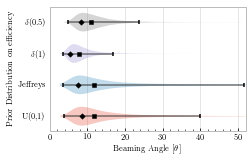

In [19]:
mweg_viols = beaming_violins(o2a_traces_mweg, priors)